<a href="https://colab.research.google.com/github/ccardoso32/MVP-Machine-Learning-Analytics/blob/main/MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ccardoso32/MVP-Machine-Learning-Analytics/blob/main/MVP_ML_&_Analytics.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# MVP: *Machine Learning & Analytics* — Breast Cancer (Classificação)

**Autor:** CAIO CARDOSO DE SOUZA  
**Data:** 15/09/2025  
**Matrícula:** 4052025000946  
**Dataset:** [Breast Cancer Wisconsin (Diagnostic) — scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)



## 1. Escopo, objetivo e definição do problema

**Contexto:** O câncer de mama é uma das principais causas de mortalidade entre mulheres. A detecção precoce aumenta a chance de tratamento eficaz e reduz custos.  
**Objetivo:** Construir e comparar modelos de *machine learning* para classificar tumores como **malignos (0)** ou **benignos (1)** a partir de 30 variáveis numéricas extraídas de imagens histopatológicas.  
**Tipo de tarefa:** Classificação binária supervisionada.  
**Área:** Dados tabulares biomédicos.  
**Valor de negócio/usuário:** Apoio à decisão clínica (triagem).


## 2. Reprodutibilidade e ambiente

In [1]:

# === Bloco 2: Setup básico e reprodutibilidade ===
import warnings; warnings.filterwarnings("ignore")

import sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn core
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score,
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)

# métricas/plots
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report,
                             ConfusionMatrixDisplay)

# reprodutibilidade
SEED = 42
np.random.seed(SEED); random.seed(SEED)

# visualização de dataframes sem quebra
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print("Python:", sys.version.split()[0], "| Seed:", SEED)


Python: 3.12.11 | Seed: 42


### 2.2 Funções auxiliares

In [3]:

def evaluate_classification(y_true, y_pred, proba=None):
    # Retorna dicionário com métricas principais
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "roc_auc": roc_auc_score(y_true, proba[:,1]) if proba is not None else np.nan
    }
    return out

def summarize_cv(results_dict):
    # Imprime média e desvio dos scores de CV e retorna ranking
    lines = []
    for name, scores in results_dict.items():
        lines.append((name, scores.mean(), scores.std()))
    lines = sorted(lines, key=lambda t: t[1], reverse=True)
    for name, m, s in lines:
        print(f"{name}: {m:.3f} ({s:.3f})")
    return lines



## 3. Dados: carga, entendimento e qualidade

**Fonte:** *scikit-learn* (`load_breast_cancer`). 569 instâncias, 30 variáveis numéricas.  
**Ética/licença:** dataset público; sem dados pessoais identificáveis. Uso educacional.  
**Prevenção de *data leakage*:** divisão treino/teste **antes** de qualquer transformação; todas as transformações ajustadas **apenas no treino** via `Pipeline/ColumnTransformer`.


In [6]:

# === Bloco 3: Carga e entendimento dos dados ===
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

df = pd.concat([X, y], axis=1)
print("Formato (linhas, colunas):", df.shape)
print("Distribuição de classes {maligno, benigno}:", dict(zip(data.target_names, np.bincount(data.target))))
df.head(10)


Formato (linhas, colunas): (569, 31)
Distribuição de classes {maligno, benigno}: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


### 3.1 Análise exploratória resumida (EDA)

,média,desvio_padrão,mínimo,máximo
mean radius,14.127292,3.524049,6.98100,28.1100
mean texture,19.289649,4.301036,9.71000,39.2800
mean perimeter,91.969033,24.298981,43.79000,188.5000
mean area,654.889104,351.914129,143.50000,2501.0000
mean smoothness,0.096360,0.014064,0.05263,0.1634


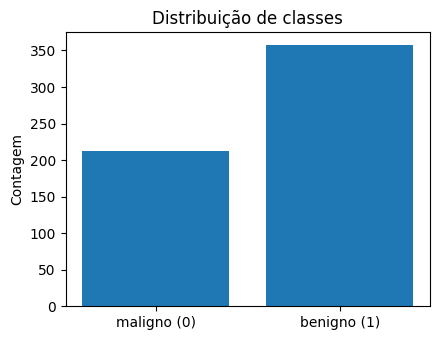

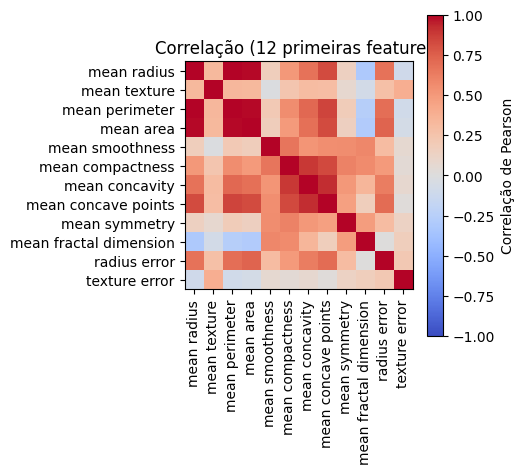

Pares com |correlação| ≥ 0.9 (didático):
  - mean radius × mean perimeter: 0.998
  - mean radius × mean area: 0.987
  - mean perimeter × mean area: 0.987
  - mean concavity × mean concave points: 0.921


In [8]:
# === 3.1 Análise exploratória resumida (EDA) ===

# 1) Estatísticas descritivas em português
desc = (
    X.describe()
     .T[["mean", "std", "min", "max"]]
     .rename(columns={
         "mean": "média",
         "std": "desvio_padrão",
         "min": "mínimo",
         "max": "máximo"
     })
)
display(desc.head())

# 2) Distribuição das classes (0 = maligno, 1 = benigno)
counts = np.unique(y, return_counts=True)
plt.figure(figsize=(4.5, 3.5))
plt.bar(["maligno (0)", "benigno (1)"], counts[1])
plt.title("Distribuição de classes")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# 3) Correlação (12 primeiras features) — mapa de calor
cols = X.columns[:12]
corr = X[cols].corr(method="pearson")

plt.figure(figsize=(5.2, 5))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlação de Pearson")
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)
plt.title("Correlação (12 primeiras features)")
plt.tight_layout()
plt.show()

# Sinalizar pares com alta correlação para orientar seleção de atributos
limiar = 0.90
pares_altamente_corr = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if abs(val) >= limiar:
            pares_altamente_corr.append((cols[i], cols[j], float(val)))

if pares_altamente_corr:
    print("Pares com |correlação| ≥", limiar, ":")
    for a, b, v in sorted(pares_altamente_corr, key=lambda t: -abs(t[2])):
        print(f"  - {a} × {b}: {v:.3f}")
else:
    print("Nenhum par com correlação muito alta (≥", limiar, ").")



## 4. Definição do target, variáveis e divisão dos dados

In [9]:

# === Bloco 4: Target e split 80/20 ===
target = "target"
features = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, test_size=0.20, stratify=y, random_state=SEED
)
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Proporção de classes (train):\n", y_train.value_counts(normalize=True).round(3))
print("Proporção de classes (test):\n", y_test.value_counts(normalize=True).round(3))


Train: (455, 30) | Test: (114, 30)
Proporção de classes (train):
 target
1    0.626
0    0.374
Name: proportion, dtype: float64
Proporção de classes (test):
 target
1    0.632
0    0.368
Name: proportion, dtype: float64



## 5. Seleção de variáveis (*Feature Selection*) — opcional, orientada por importância


**Critério adaptativo:**  
1) Ajustamos um **RandomForest** no treino com *imputação* para obter `feature_importances_`.  
2) Se a razão `max_importance / min_importance < 3`, entendemos que os "pesos" são relativamente parecidos → **mantemos todas** as 30 variáveis (preferência por interpretabilidade e simplicidade).  
3) Caso contrário, mantemos o menor conjunto de variáveis que acumule **≥95%** da importância total (com no mínimo 12 features), e reportamos a lista final.  
4) Como checagem, também calculamos o ranking univariado (`SelectKBest(f_classif)`) e mostramos a interseção com as escolhidas.


> **Nota:** embora este dataset seja pequeno (569 amostras, 30 variáveis),
incluímos a etapa de *feature selection* **por fins educacionais**, para documentar o processo,
mostrar como evitar *data leakage* e observar o impacto na validação cruzada.


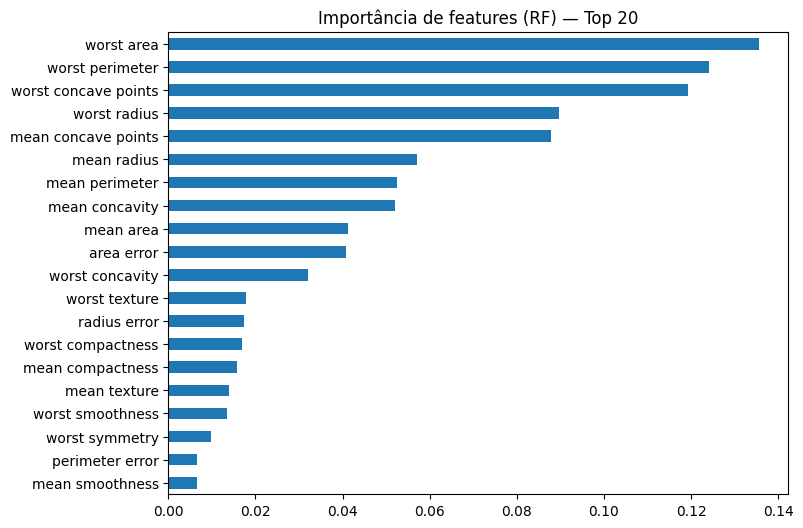

Razão max/min de importância: 34.65
Decisão: select_subset
Nº de colunas finais: 20 / 30
Interseção RF-Importância vs SelectKBest: 19 colunas
['area error', 'mean area', 'mean compactness', 'mean concave points', 'mean concavity', 'mean perimeter', 'mean radius', 'mean texture', 'perimeter error', 'radius error'] ...


'Os pesos variaram bastante (max/min = 34.65). Mantivemos 20 variáveis que acumulam ≥95% da importância (RF). Isso tende a reduzir variância e tempo de treino, com baixo custo de viés.'

In [10]:

# === Bloco 5: Feature Selection ===
from sklearn.feature_selection import SelectKBest, f_classif

# 1) RF só com imputação
num_cols_all = X_train.columns.tolist()
rf_fs = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1))
])
rf_fs.fit(X_train[num_cols_all], y_train)
importances = rf_fs.named_steps["rf"].feature_importances_
imp_ser = pd.Series(importances, index=num_cols_all).sort_values(ascending=False)

# Plot top-20 para diagnóstico
ax = imp_ser.head(20).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Importância de features (RF) — Top 20")
plt.show()

ratio = imp_ser.max() / max(imp_ser.min(), 1e-12)
cum = imp_ser.cumsum()

# 2) Decisão adaptativa
if ratio < 3.0:
    decision = "keep_all"
    final_num_cols = num_cols_all  # pesos semelhantes → manter todas
else:
    cutoff_idx = np.argmax(cum.values >= 0.95)  # menor índice que atinge 95%
    cutoff_idx = max(cutoff_idx, 11)            # garantir pelo menos 12 colunas
    final_num_cols = imp_ser.index[:cutoff_idx+1].tolist()
    decision = "select_subset"

print(f"Razão max/min de importância: {ratio:.2f}")
print(f"Decisão: {decision}")
print(f"Nº de colunas finais: {len(final_num_cols)} / {len(num_cols_all)}")

# 3) Checagem com SelectKBest (mesmo tamanho do conjunto escolhido)
k_sel = len(final_num_cols)
skb = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("std", StandardScaler()),
    ("skb", SelectKBest(score_func=f_classif, k=k_sel))
])
skb.fit(X_train[num_cols_all], y_train)
mask = skb.named_steps["skb"].get_support()
skb_cols = X_train.columns[mask].tolist()

inter = set(final_num_cols).intersection(skb_cols)
print(f"Interseção RF-Importância vs SelectKBest: {len(inter)} colunas")
print(sorted(list(inter))[:10], "...")

# Vamos registrar o racional em texto para o relatório
if decision == "keep_all":
    rationale_text = (
        "Os pesos relativos estão próximos (max/min < 3). Mantivemos as 30 variáveis "
        "para preservar interpretabilidade e evitar risco de remover sinais úteis; "
        "models baseados em árvore e regressão logística lidam bem com esse tamanho."
    )
else:
    rationale_text = (
        f"Os pesos variaram bastante (max/min = {ratio:.2f}). Mantivemos "
        f"{len(final_num_cols)} variáveis que acumulam ≥95% da importância (RF). "
        "Isso tende a reduzir variância e tempo de treino, com baixo custo de viés."
    )

rationale_text



### 5.1 Efeito da *feature selection*: antes vs. depois (CV estratificada 10-fold)

Para fins **didáticos**, comparamos rapidamente 3 modelos (Regressão Logística, RandomForest, KNN)
**antes** (todas as 30 variáveis) e **depois** (conjunto `final_num_cols`) da seleção,
sempre dentro de *pipelines* para evitar *leakage*. Reportamos média e desvio-padrão da **acurácia (CV=10)**
e o **delta** entre as versões.


Comparação (acurácia CV=10) — antes vs. depois da FS


,antes_mean,antes_std,depois_mean,depois_std,delta_mean
modelo,,,,,
LogReg,0.9824,0.0133,0.9802,0.0182,-0.0022
RF,0.9628,0.0337,0.9627,0.0278,-0.0001
KNN,0.9671,0.0148,0.9758,0.0207,0.0087


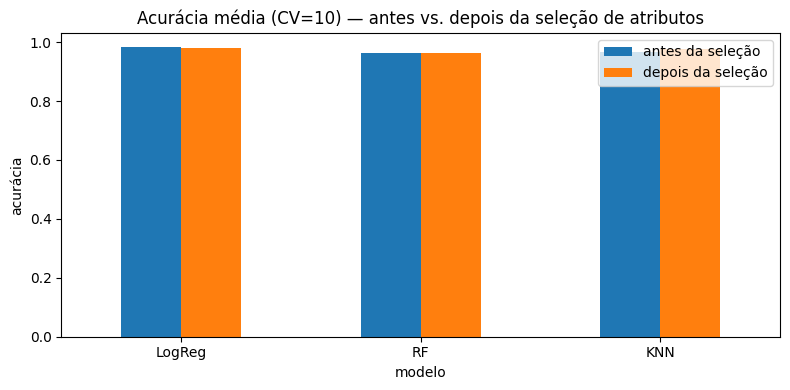

In [17]:

# === Bloco 5.1: Comparação antes/depois da FS (CV=10) ===

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Pipelines "antes" (todas as colunas)
all_cols = X_train.columns.tolist()
pre_none_all = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), all_cols)])
pre_std_all  = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), all_cols)])

models_before = {
    "LogReg": Pipeline([("pre", pre_std_all),  ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF"    : Pipeline([("pre", pre_none_all), ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN"   : Pipeline([("pre", pre_std_all),  ("m", KNeighborsClassifier())])
}

# Pipelines "depois" (features finais)
pre_none_fs = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), final_num_cols)])
pre_std_fs  = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), final_num_cols)])

models_after = {
    "LogReg": Pipeline([("pre", pre_std_fs),  ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF"    : Pipeline([("pre", pre_none_fs), ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN"   : Pipeline([("pre", pre_std_fs),  ("m", KNeighborsClassifier())])
}

rows = []
for name in ["LogReg", "RF", "KNN"]:
    sc_before = cross_val_score(models_before[name], X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    sc_after  = cross_val_score(models_after[name],  X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    rows.append({
        "modelo": name,
        "antes_mean": sc_before.mean(), "antes_std": sc_before.std(),
        "depois_mean": sc_after.mean(), "depois_std": sc_after.std(),
        "delta_mean": sc_after.mean() - sc_before.mean()
    })

cmp_df = pd.DataFrame(rows).set_index("modelo").round(4)
print("Comparação (acurácia CV=10) — antes vs. depois da FS")
display(cmp_df)

# --- Visualização (português) ---
ax = cmp_df[["antes_mean", "depois_mean"]].plot(kind="bar", figsize=(8,4))
ax.set_title("Acurácia média (CV=10) — antes vs. depois da seleção de atributos")
ax.set_ylabel("acurácia")
ax.set_xlabel("modelo")
plt.xticks(rotation=0)

# legenda mais clara
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["antes da seleção", "depois da seleção"], loc="best")
plt.tight_layout()
plt.show()


### 5.2 Comparação de *Feature Selection* básica vs. refinada (remoção de variáveis altamente correlacionadas)

Após avaliarmos a seleção de variáveis baseada na importância (Random Forest) e garantirmos um conjunto reduzido de colunas relevantes, fazemos um passo **refinado** para verificar possíveis pares de variáveis ainda **altamente correlacionadas** (|r| ≥ 0.90).  

**Racional do refinamento:**
1. Identificamos pares de variáveis muito correlacionadas no conjunto escolhido.
2. Para cada par, removemos a variável com **menor importância relativa** segundo o ranking da Random Forest.
3. Assim, preservamos variáveis mais informativas e reduzimos redundância no modelo.
4. Avaliamos novamente os três modelos (Regressão Logística, Floresta Aleatória e KNN), comparando:
   - **FS básica** (todas as variáveis selecionadas pela estratégia inicial).
   - **FS refinada** (mesmo conjunto, mas removendo colunas redundantes).

**Objetivo:** observar se a remoção de redundâncias melhora (ou mantém) a acurácia média em validação cruzada (CV=10), com menor custo de dimensionalidade.

> Em resumo: a FS refinada busca um equilíbrio entre **simplicidade e desempenho**, garantindo que as variáveis escolhidas sejam ao mesmo tempo relevantes e não redundantes.


Limiar de correlação (|r|): 0.9
Pares encontrados (|r| >= 0.9): 21
 - mean radius × mean perimeter: 0.998
 - worst perimeter × worst radius: 0.993
 - mean radius × mean area: 0.989
 - mean perimeter × mean area: 0.988
 - worst area × worst radius: 0.986
 - worst area × worst perimeter: 0.979
 - worst perimeter × mean perimeter: 0.971
 - radius error × perimeter error: 0.971
 - worst radius × mean radius: 0.970
 - worst radius × mean perimeter: 0.970

Variáveis removidas na FS refinada por alta correlação: ['mean area', 'mean concave points', 'mean concavity', 'mean perimeter', 'mean radius', 'mean texture', 'perimeter error', 'radius error', 'worst perimeter', 'worst radius']
Qtd colunas — FS básica: 20 | FS refinada: 10

Comparação (acurácia CV=10) — FS básica vs. FS refinada


,modelo,antes_mean,antes_std,refinada_mean,refinada_std,delta_mean
0,Regressão Logística,0.9802,0.0182,0.9737,0.0190,-0.0066
1,Floresta Aleatória,0.9627,0.0278,0.9539,0.0331,-0.0087
2,KNN,0.9758,0.0207,0.9583,0.0182,-0.0175


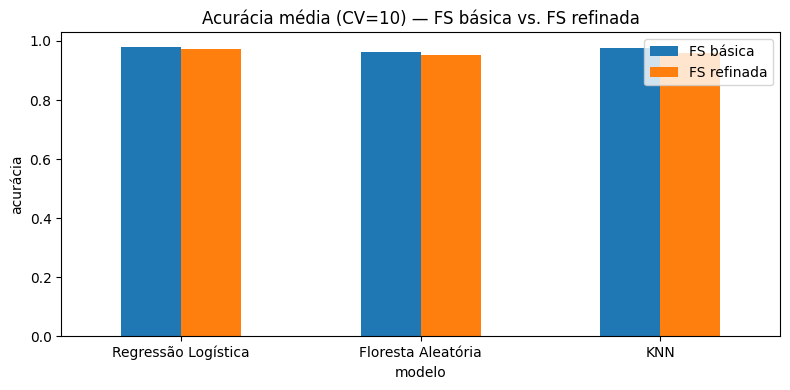


Feature selection refinada (remoção de variáveis altamente correlacionadas) removeu 10 coluna(s) redundantes, resultando em 10 variáveis finais. Em média, observamos uma leve queda média de acurácia (Δ médio = -0.0109). O melhor desempenho após o refinamento foi com **Regressão Logística** (acurácia média=0.9737).


In [21]:
# === 5.2 FS básica vs FS refinada (remoção de redundâncias por alta correlação) ===

# --- 1) Encontrar pares ainda altamente correlacionados dentro de final_num_cols
thr = 0.90  # limiar didático (|r| >= 0.90)
corr_mat = X_train[final_num_cols].corr(method="pearson").abs()

pares_alto_r = []
to_drop = set()

# examinamos somente o triângulo superior para não repetir pares
cols = final_num_cols
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr_mat.loc[cols[i], cols[j]]
        if r >= thr:
            pares_alto_r.append((cols[i], cols[j], float(r)))

# --- 2) Escolher qual remover em cada par: fica a de MAIOR importância; remove a de MENOR
for a, b, r in sorted(pares_alto_r, key=lambda t: -t[2]):  # começa dos mais altos
    if a in to_drop or b in to_drop:
        continue  # já resolvido por outro par
    imp_a = float(imp_ser.get(a, 0.0))
    imp_b = float(imp_ser.get(b, 0.0))
    drop = a if imp_a < imp_b else b
    to_drop.add(drop)

refined_cols = [c for c in final_num_cols if c not in to_drop]

print(f"Limiar de correlação (|r|): {thr}")
print(f"Pares encontrados (|r| >= {thr}): {len(pares_alto_r)}")
if pares_alto_r:
    for a, b, r in sorted(pares_alto_r, key=lambda t: -t[2])[:10]:
        print(f" - {a} × {b}: {r:.3f}")
print(f"\nVariáveis removidas na FS refinada por alta correlação: {sorted(list(to_drop))}")
print(f"Qtd colunas — FS básica: {len(final_num_cols)} | FS refinada: {len(refined_cols)}")

# --- 3) Preprocessadores equivalentes aos do 5.1 (para manter comparação justa)
# LogReg / KNN: imputação + padronização
pre_std_fs = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("sc", StandardScaler())]), final_num_cols)]
)
pre_std_refined = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("sc", StandardScaler())]), refined_cols)]
)

# RF: somente imputação (sem StandardScaler), como no 5.1
pre_none_fs = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), final_num_cols)]
)
pre_none_refined = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), refined_cols)]
)

# --- 4) Modelos (mesmos do 5.1, com preprocessamento coerente)
modelos_basicos = {
    "LogReg": Pipeline([("pre", pre_std_fs),
                        ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF":     Pipeline([("pre", pre_none_fs),
                        ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN":    Pipeline([("pre", pre_std_fs),
                        ("m", KNeighborsClassifier())]),
}

modelos_refinados = {
    "LogReg": Pipeline([("pre", pre_std_refined),
                        ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF":     Pipeline([("pre", pre_none_refined),
                        ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN":    Pipeline([("pre", pre_std_refined),
                        ("m", KNeighborsClassifier())]),
}

# --- 5) Avaliação em CV=10 (acurácia)
rows = []
for nome in ["LogReg", "RF", "KNN"]:
    sc_b = cross_val_score(modelos_basicos[nome],  X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    sc_r = cross_val_score(modelos_refinados[nome], X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    rows.append({
        "modelo_en": nome,
        "antes_mean": sc_b.mean(), "antes_std": sc_b.std(),
        "refinada_mean": sc_r.mean(), "refinada_std": sc_r.std(),
        "delta_mean": sc_r.mean() - sc_b.mean()
    })

cmp_ref = pd.DataFrame(rows)

# Mapear nomes para PT-BR
nome_pt = {"LogReg": "Regressão Logística", "RF": "Floresta Aleatória", "KNN": "KNN"}
cmp_ref.insert(0, "modelo", cmp_ref["modelo_en"].map(nome_pt))
cmp_ref = cmp_ref.drop(columns=["modelo_en"])

print("\nComparação (acurácia CV=10) — FS básica vs. FS refinada")
display(cmp_ref.style.format({
    "antes_mean": "{:.4f}", "antes_std": "{:.4f}",
    "refinada_mean": "{:.4f}", "refinada_std": "{:.4f}",
    "delta_mean": "{:+.4f}"
}))

# --- 6) Gráfico em português
ax = cmp_ref.set_index("modelo")[["antes_mean", "refinada_mean"]].plot(kind="bar", figsize=(8,4))
plt.title("Acurácia média (CV=10) — FS básica vs. FS refinada")
plt.ylabel("acurácia")
plt.xlabel("modelo")
plt.xticks(rotation=0)
plt.legend(["FS básica", "FS refinada"])
plt.tight_layout()
plt.show()

# --- 7) Texto interpretativo automático (para o relatório)
melhor = cmp_ref.sort_values("refinada_mean", ascending=False).iloc[0]
delta_global = cmp_ref["delta_mean"].mean()

if abs(delta_global) < 0.005:
    efeito = "praticamente estável"
elif delta_global > 0:
    efeito = "um ganho médio de acurácia"
else:
    efeito = "uma leve queda média de acurácia"

rationale_fs_refinada = (
    "Feature selection refinada (remoção de variáveis altamente correlacionadas) "
    f"removeu {len(to_drop)} coluna(s) redundantes, resultando em {len(refined_cols)} variáveis finais. "
    f"Em média, observamos {efeito} (Δ médio = {delta_global:+.4f}). "
    f"O melhor desempenho após o refinamento foi com **{melhor['modelo']}** "
    f"(acurácia média={melhor['refinada_mean']:.4f})."
)
print("\n" + rationale_fs_refinada)


## 6. Tratamento dos dados e Pipeline de pré-processamento

In [23]:

# === Bloco 6: Pré-processamento com as features finais (final_num_cols) ===
# OBS: final_num_cols foi definido no bloco 5 (FS básica/refinada)

num_cols = final_num_cols  # usa a decisão do bloco 5

# Pipelines numéricos
numeric_pipe_none = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
])  # sem escala

numeric_pipe_std = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

numeric_pipe_min = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),
])

# ColumnTransformers (um por estratégia)
preproc_none = ColumnTransformer([("num", numeric_pipe_none, num_cols)])
preproc_std  = ColumnTransformer([("num", numeric_pipe_std,  num_cols)])
preproc_min  = ColumnTransformer([("num", numeric_pipe_min,  num_cols)])

print(f"Colunas usadas nos pipelines: {len(num_cols)}")



Colunas usadas nos pipelines: 20


## 7. Baseline e modelos candidatos

In [24]:
# === Bloco 7: Definição dos modelos e montagem das pipelines ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

modelos = {
    "LR":  LogisticRegression(max_iter=1000, random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "CART": DecisionTreeClassifier(random_state=SEED),
    "NB":  GaussianNB(),
    "SVM": SVC(probability=True, random_state=SEED),
    "Bag": BaggingClassifier(random_state=SEED),
    "RF":  RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "ET":  ExtraTreesClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "Ada": AdaBoostClassifier(random_state=SEED),
    "GB":  GradientBoostingClassifier(random_state=SEED),
}

voting = VotingClassifier(
    estimators=[("lr", modelos["LR"]), ("rf", modelos["RF"]), ("svm", modelos["SVM"])],
    voting="soft", n_jobs=-1
)

pipelines = {}

pipelines["Dummy"] = Pipeline([("pre", preproc_none),
                               ("modelo", DummyClassifier(strategy="most_frequent"))])

for tag_pre, pre in [("none", preproc_none), ("std", preproc_std), ("min", preproc_min)]:
    for nome, m in modelos.items():
        pipelines[f"{nome}-{tag_pre}"] = Pipeline([("pre", pre), ("modelo", m)])

for tag_pre, pre in [("none", preproc_none), ("std", preproc_std), ("min", preproc_min)]:
    pipelines[f"vot-{tag_pre}"] = Pipeline([("pre", pre), ("modelo", voting)])


### 7.1 Treino e avaliação rápida (CV + boxplot)

Top 10 pipelines (média de acurácia em CV=10):


,pipeline,acc_mean,acc_std
0,SVM-min,0.9802,0.0152
1,LR-std,0.9802,0.0182
2,vot-std,0.9802,0.0152
3,vot-min,0.9802,0.0154
4,SVM-std,0.9758,0.0153
5,KNN-min,0.9758,0.0207
6,KNN-std,0.9758,0.0207
7,ET-std,0.9737,0.0236
8,Ada-std,0.9737,0.0254
9,ET-none,0.9737,0.0236


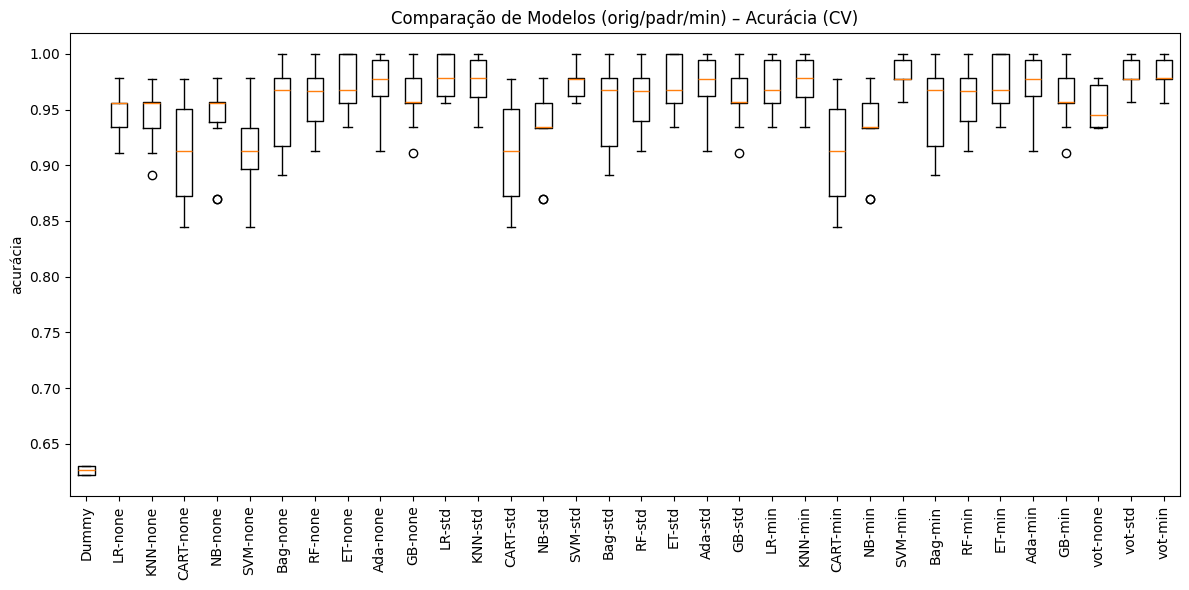

In [25]:
# === Bloco 7.1: Avaliação rápida em CV (acurácia) e boxplot ===
cv_scores = {}
names, results = [], []

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = scores
    names.append(name)
    results.append(scores)

def _resumo(scores_dict):
    rows = []
    for k, v in scores_dict.items():
        rows.append({"pipeline": k, "acc_mean": v.mean(), "acc_std": v.std()})
    return pd.DataFrame(rows).sort_values("acc_mean", ascending=False).reset_index(drop=True)

resumo_df = _resumo(cv_scores)
print("Top 10 pipelines (média de acurácia em CV=10):")
display(resumo_df.head(10).style.format({"acc_mean": "{:.4f}", "acc_std": "{:.4f}"}))

plt.figure(figsize=(12, 6))
plt.boxplot(results)
plt.xticks(rotation=90, ticks=range(1, len(names)+1), labels=names)
plt.title("Comparação de Modelos (orig/padr/min) – Acurácia (CV)")
plt.ylabel("acurácia")
plt.tight_layout()
plt.show()


## 8. Validação e Otimização de Hiperparâmetros (GridSearch KNN)

In [29]:
# === Bloco 8: GridSearch do KNN em todos os pré-processamentos ===
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# grade (didática) para KNN
param_grid_knn = {
    "modelo__n_neighbors": list(range(1, 23, 2)),              # 1,3,5,...,21
    "modelo__metric": ["euclidean", "manhattan", "minkowski"],
}

# dicionário dos pré-processamentos que já existem no caderno
pre_dict = {
    "sem":          preproc_none,   # imputação apenas
    "padronizado":  preproc_std,    # imputação + StandardScaler
    "normalizado":  preproc_min,    # imputação + MinMaxScaler
}

melhor_global = {
    "pre_name": None,
    "best_score": -1.0,
    "gs": None,
}

print("# GridSearchCV para KNN")
for pre_name, pre in pre_dict.items():
    print(f"\n> Rodando KNN com pré-processamento: {pre_name}")
    pipe_knn = Pipeline([("pre", pre), ("modelo", KNeighborsClassifier())])
    gs = GridSearchCV(
        estimator=pipe_knn,
        param_grid=param_grid_knn,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    gs.fit(X_train, y_train)
    print(f"  Melhores params (CV): {gs.best_params_}")
    print(f"  Melhor score (CV): {gs.best_score_:.4f}")

    if gs.best_score_ > melhor_global["best_score"]:
        melhor_global["best_score"] = gs.best_score_
        melhor_global["pre_name"]   = pre_name
        melhor_global["gs"]         = gs

# melhor KNN encontrado (com o melhor pré-processamento)
best_knn = melhor_global["gs"].best_estimator_
print("\n=== Resumo do melhor KNN ===")
print(f"Pré-processamento: {melhor_global['pre_name']}")
print(f"Melhor score (CV): {melhor_global['best_score']:.4f}")
print(f"Melhores parâmetros: {melhor_global['gs'].best_params_}")

# 👉 incluir o KNN otimizado nos pipelines e nas métricas de CV
pipelines["KNN_otimizado"] = best_knn
cv_scores["KNN_otimizado"] = cross_val_score(best_knn, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)

# (opcional) Tabelinha rápida comparando KNN base x KNN otimizado, se o base existir
if "KNN" in pipelines:
    base_mean = cv_scores["KNN"].mean()
    opt_mean  = cv_scores["KNN_otimizado"].mean()
    print("\nComparação rápida — KNN (base) vs KNN (otimizado)")
    print(f"KNN (base)      — média CV: {base_mean:.4f}")
    print(f"KNN (otimizado) — média CV: {opt_mean:.4f}  | Δ = {opt_mean - base_mean:+.4f}")


# GridSearchCV para KNN

> Rodando KNN com pré-processamento: sem
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 5}
  Melhor score (CV): 0.9495

> Rodando KNN com pré-processamento: padronizado
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 5}
  Melhor score (CV): 0.9802

> Rodando KNN com pré-processamento: normalizado
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 9}
  Melhor score (CV): 0.9825

=== Resumo do melhor KNN ===
Pré-processamento: normalizado
Melhor score (CV): 0.9825
Melhores parâmetros: {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 9}


## 9. Avaliação final, análise de erros e limitações

Melhor pipeline por CV: KNN_otimizado | média=0.9825

Métricas (teste):
              precision    recall  f1-score   support

     Maligno     0.9512    0.9286    0.9398        42
     Benigno     0.9589    0.9722    0.9655        72

    accuracy                         0.9561       114
   macro avg     0.9551    0.9504    0.9526       114
weighted avg     0.9561    0.9561    0.9560       114



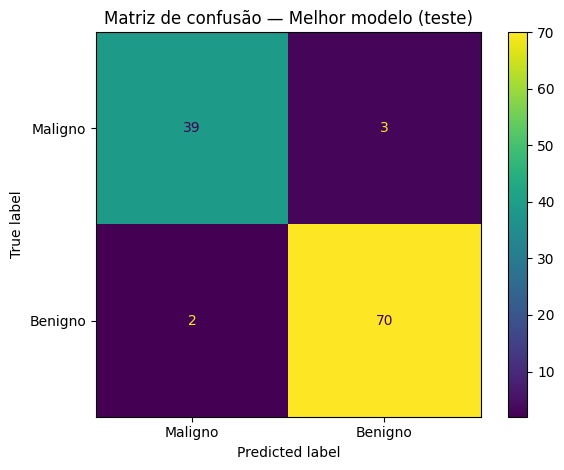

In [30]:
# === Bloco 9: Seleção do melhor por CV e avaliação em teste ===
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1) selecionar o melhor pipeline pela média de CV
best_name, best_mean = None, -np.inf
for name, scores in cv_scores.items():
    if scores.mean() > best_mean:
        best_mean = scores.mean()
        best_name = name

best_pipe = pipelines[best_name]
print(f"Melhor pipeline por CV: {best_name} | média={best_mean:.4f}")

# 2) treinar no conjunto de treino completo
best_pipe.fit(X_train, y_train)

# 3) avaliação no teste
y_pred  = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe, "predict_proba") else None

# nomes em PT-BR para o relatório e matriz de confusão
labels_pt = ["Maligno", "Benigno"]

print("\nMétricas (teste):")
print(classification_report(y_test, y_pred, target_names=labels_pt, digits=4))

ConfusionMatrixDisplay.from_estimator(
    best_pipe, X_test, y_test, display_labels=labels_pt
)
plt.title("Matriz de confusão — Melhor modelo (teste)")
plt.tight_layout()
plt.show()

# 4) Importância de variáveis (se o modelo suportar)
modelo_final = best_pipe.named_steps.get("modelo")
if hasattr(modelo_final, "feature_importances_"):
    importances = modelo_final.feature_importances_
    imp_ser = pd.Series(importances, index=final_num_cols).sort_values(ascending=False)
    print("\nTop 15 importâncias (disponível):")
    display(imp_ser.head(15))
    ax = imp_ser.head(15).plot(kind="barh", figsize=(8, 5))
    ax.invert_yaxis()
    plt.title("Importância de variáveis (disponível)")
    plt.tight_layout()
    plt.show()


## 10. Refit com todo o dataset e salvando artefatos

In [35]:
# === Bloco 10: Refit no dataset completo (produção) e salvando artefatos ===
# Reutiliza: best_pipe (do Bloco 9), X e y originais, final_num_cols

# 1) Refit do melhor pipeline com TODO o dataset (X,y)
best_pipe.fit(X, y)

# 2) Salvar modelo e metadados (útil para reproduzir/servir)
modelo_path = "breast_cancer_best_pipeline.joblib"
meta_path   = "breast_cancer_metadata.json"

dump(best_pipe, modelo_path)

# Metadados mínimos (evitar data leakage: só nomes, versões e esquema)
labels_pt = ["Maligno", "Benigno"]  # mapeamento usado nos relatórios
metadata = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "sklearn_version": sklearn.__version__,
    "features": final_num_cols,
    "target_labels": labels_pt,
    "pipeline_repr": str(best_pipe)[:1000]
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(f"✔ Modelo salvo em: {modelo_path}")
print(f"✔ Metadados salvos em: {meta_path}")


✔ Modelo salvo em: breast_cancer_best_pipeline.joblib
✔ Metadados salvos em: breast_cancer_metadata.json


## 11. Predição em novos dados

In [37]:
# === Bloco 11: Predição em novos dados ===
# Reutiliza: best_pipe já treinado no Bloco 10

import joblib  # <-- garante o load aqui

# 1) Exemplo didático de "novos dados"
novos = X.sample(3, random_state=SEED).reset_index(drop=True)

# 2) Predição com o pipeline em memória (treinado no Bloco 10)
pred = best_pipe.predict(novos)

# Probabilidade (se houver)
proba_pos = None
if hasattr(best_pipe, "predict_proba"):
    probas = best_pipe.predict_proba(novos)
    idx_pos = list(best_pipe.classes_).index(1) if 1 in best_pipe.classes_ else 1
    proba_pos = probas[:, idx_pos]

# 3) Saída amigável
map_pt = {0: "Maligno", 1: "Benigno"}
saida = novos.copy()
saida["predição"] = [map_pt[int(v)] for v in pred]
if proba_pos is not None:
    saida["prob_benigno"] = proba_pos.round(4)

print("▶ Predições em novos dados:")
display(saida)

# 4) (Opcional) Checagem de carga do artefato salvo no Bloco 10
#    (se mudar o nome/caminho no Bloco 10, ajuste aqui também)
artefato = "breast_cancer_best_pipeline.joblib"
loaded_pipe = joblib.load(artefato)  # <-- usa joblib.load, não 'load'

demo_preds = loaded_pipe.predict(novos.head(1))
print("\nChecagem de carga do artefato:")
print(f"  Predição para 1 amostra: {map_pt[int(demo_preds[0])]}")


▶ Predições em novos dados:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,predição,prob_benigno
0,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,0.3961,1.0440,2.497,30.29,0.006953,0.01911,0.02701,0.01037,0.01782,0.003586,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.1015,0.3014,0.08750,Benigno,1.0
1,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,0.7888,0.7975,5.486,96.05,0.004444,0.01652,0.02269,0.01370,0.01386,0.001698,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589,Maligno,0.0
2,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,0.4743,0.7859,3.094,48.31,0.006240,0.01484,0.02813,0.01093,0.01397,0.002461,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.1514,0.2837,0.08019,Maligno,0.0



Checagem de carga do artefato:
  Predição para 1 amostra: Benigno
